### Audio Classification in Pytorch
This notebook describes the steps taken in realizing a Convolutional Neural Network (CNN), usable for classification in audio classification. The goal is to research the use of CNNs in audio classification and how to go about preprocessing audio data to make it useful for training a model. 

#### 1. Introduction
This assignment aims to solve the following problem:

"The company SLIFTS (Smart Lifts in Floor Transition Systems) want to expand its elevator capabilities to handle spoken commands. In the aftermath of the global 2020 COVID pandemic, the company has noted a sharp decline in the number of passengers that use their elevators. Marketing research has shown that people are hesitant to touch physical buttons in the elevator. As one user noted “this up-button looks really yucky, I can almost see the germs crawling on it!”. The situation is extremely serious and people are even doing previously unthinkable things like taking the stairs, which has to be prevented in all cases. To resolve this problem, SLIFTS has hired Zuyd Hogeschool to research and develop elevators with voice command capabilities."

To solve this problem, the following points will be looked at closely:
1. Preprocessing audio data for training a CNN
2. Preparing the dataset for training. This includes making decisions on splitting the dataset.
3. Designing the model.
4. Implementing the model for training.
5. Evaluating the output of the model after training.
6. Finetuning the model after evaluating the results.

Note that the advisory and conclusion is included in a separate document.

#### 2. Data Collection
For any machine learning/ai project, a dataset is needed to train, test and evaluate a model once it's built in code. In the case of recognizing speech commands, a dataset is needed where these speech commands, like 'yes' or 'down', need to be made audible. Fortunately, such a dataset is already available on [Kaggle](https://www.kaggle.com/datasets/antfilatov/mini-speech-commands/data).

This dataset includes the following commands: down, go, left, no, right, stop, up, yes.

In [21]:
'''To make a custom dataset, a class will be made that inherits its properties
from the pytorch dataset class'''
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
from torch import nn
import torch
import torch.nn as nn
import torchaudio.transforms as T

class LiftCommandDataset(Dataset):
    def __init__(self, root_dir: str, transform=None, target_len: int = 16000):
        self.root_dir = root_dir
        self.file_paths = []
        self.labels = []
        self.label_map = {}
        self.transform = transform
        self.target_len = target_len

        '''Recursively load all files and append corresponding labels from folder name'''
        '''Please optimize :('''
        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            if os.path.isdir(label_dir):
                self.label_map[label] = len(self.label_map)
                for file_name in os.listdir(label_dir):
                    if file_name.endswith('.wav'):
                        self.file_paths.append(os.path.join(label_dir, file_name))
                        self.labels.append(self.label_map[label])
        print("Label Map:", self.label_map, "\n")

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index: int):
        file_path = self.file_paths[index]
        waveform, sample_rate = torchaudio.load(file_path)
        
        '''Convert stereo to mono if necessary'''
        if waveform.shape[0] == 2:  
            waveform = waveform.mean(dim=0, keepdim=True)

        waveform = self._pad_or_truncate(waveform)

        if self.transform:
            waveform = self.transform(waveform)
        
        label = self.labels[index]

        '''CrossEntropyLoss requires LongTensor for Label'''
        return waveform, torch.tensor(label, dtype=torch.long)
    
    def _pad_or_truncate(self, waveform):
        num_samples = waveform.shape[1]

        if num_samples > self.target_len:
            waveform = waveform[:, :self.target_len]
            #print("Debug: sample > target len")
        elif num_samples < self.target_len:
            pad_amount = self.target_len - num_samples
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount))
            #print("Debug: sample < target len")
        
        return waveform

#### 3. Data Preprocessing


To make audio file formats usable for training a CNN, they will need to be converted to an image of some sort. For the given problem, there are two options to achieve this:
1. Mel-spectrogram: full time-frequency representation of an audio signal
2. Mel-frequency Cepstral Coefficients (MFCC): reduced set of coefficients that summarize the spectral characteristics.

Both frequencies make use of the Mel scale, which is a scale of the pitches that approximately represent the way humans perceive sound. The Mel-spectrogram however captures a full time-frequency representation of the audio signal, while Mel-frequency only captures the most important characteristics of the audio signal.

For this project, Mel-spectrogram will be used since it might give the model more opportunities to understand underlying patterns.

In [22]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [23]:
waveform, sample_rate = torchaudio.load("./mini_speech_commands/down/0a9f9af7_nohash_0.wav")

print_stats(waveform, sample_rate=sample_rate)

Sample Rate: 16000
Shape: (1, 13654)
Dtype: torch.float32
 - Max:      0.115
 - Min:     -0.225
 - Mean:     0.003
 - Std Dev:  0.030

tensor([[0.0018, 0.0030, 0.0028,  ..., 0.0253, 0.0297, 0.0178]])



In [24]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

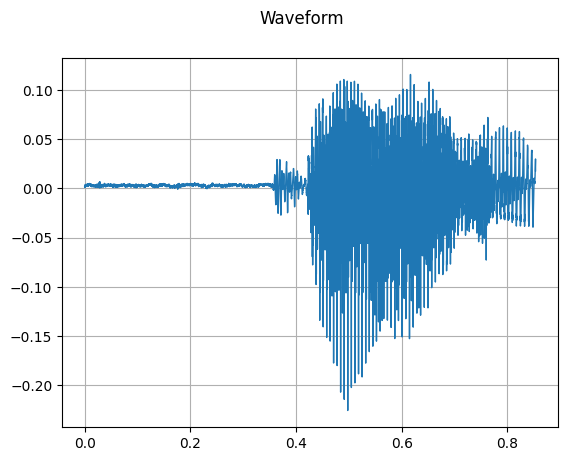

In [25]:
plot_waveform(waveform, sample_rate)

In [26]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

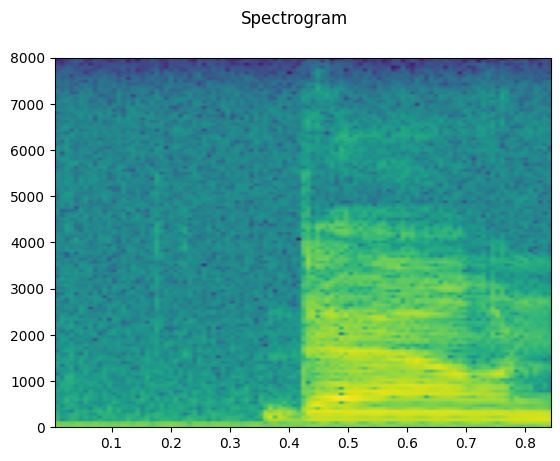

In [27]:
plot_specgram(waveform, sample_rate)

In [28]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [29]:
play_audio(waveform, sample_rate)

##### Creating a test and validation split

In [30]:
def apply_transforms(waveform):
    transforms = [
        T.MelSpectrogram(sample_rate=16000, n_mels=64, n_fft=400, hop_length=160),
        T.AmplitudeToDB(),
        T.FrequencyMasking(freq_mask_param=10),
        T.TimeMasking(time_mask_param=20)
    ]
    
    for t in transforms:
        waveform = t(waveform)  # Apply each transform sequentially
    
    return waveform

In [31]:
root_dir = './mini_speech_commands'

dataset = LiftCommandDataset(root_dir, transform=apply_transforms)

Label Map: {'down': 0, 'go': 1, 'up': 2, 'yes': 3, 'stop': 4, 'left': 5, 'no': 6, 'right': 7} 



In [32]:
train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.5, 0.25, 0.25])

In [33]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

In [34]:
for batch_waveforms in train_loader:
    print(batch_waveforms)

[tensor([[[[ -41.3684,  -27.5996,  -34.2886,  ...,  -25.7384,  -26.2561,
            -32.0842],
          [ -39.2613,  -27.4623,  -33.8294,  ...,  -26.0511,  -25.0677,
            -26.1726],
          [ -36.2490,  -27.3939,  -33.0060,  ...,  -27.4723,  -23.0360,
            -21.3978],
          ...,
          [ -53.3738,  -50.1981,  -52.6245,  ...,  -53.1242,  -52.4086,
            -44.7505],
          [ -49.5018,  -51.3560,  -52.8701,  ...,  -48.9696,  -50.3762,
            -48.1705],
          [ -54.8216,  -56.9481,  -54.6560,  ...,  -48.9259,  -52.0683,
            -50.1737]]],


        [[[-100.0000, -100.0000, -100.0000,  ...,  -51.2564,  -65.9595,
            -68.7748],
          [-100.0000, -100.0000, -100.0000,  ...,  -52.1327,  -66.5459,
            -68.4442],
          [-100.0000, -100.0000, -100.0000,  ...,  -57.2798,  -69.3360,
            -67.9004],
          ...,
          [-100.0000, -100.0000, -100.0000,  ...,  -79.4554,  -82.0438,
            -82.2841],
          [-100

In [35]:
len(dataset)

8000

#### 5. Model Design

Vgg network using concolutional layers
The network will consist of 4 convolutional layers, a flatten layer, linear tranfsormation and softmax

input spectrogram is 64 × 101 (Mel-Spectrogram: n_mels=64, hop_length=160)

#### 6. Training Model

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


In [ ]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.3),   

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.3),  

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Dropout(p=0.4),  

    nn.Flatten(),
    nn.Linear(128 * 5 * 8, 8),
    
    #'''EntropyLoss already incorporates Softmax, making Softmax redundant'''
    #nn.Softmax(dim=1)
    ).to(device)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (699241708.py, line 17)

In [ ]:
'''Setting up constants/hyperparameters'''
LEARNING_RATE = 0.0005
EPOCHS = 30

In [ ]:
train_history = []
val_history = []

In [ ]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

epoch: 0	train loss: 2.4276	val loss: 2.0749
epoch: 1	train loss: 2.0687	val loss: 2.0553
epoch: 2	train loss: 2.0161	val loss: 1.9678
epoch: 3	train loss: 1.8901	val loss: 1.8011
epoch: 4	train loss: 1.7428	val loss: 1.6587
epoch: 5	train loss: 1.5885	val loss: 1.5635
epoch: 6	train loss: 1.5088	val loss: 1.4326
epoch: 7	train loss: 1.3451	val loss: 1.3396
epoch: 8	train loss: 1.2479	val loss: 1.2008
epoch: 9	train loss: 1.1599	val loss: 1.0993
epoch: 10	train loss: 1.0617	val loss: 1.0400
epoch: 11	train loss: 0.9744	val loss: 1.0108
epoch: 12	train loss: 0.9310	val loss: 1.0035
epoch: 13	train loss: 0.8672	val loss: 0.8925
epoch: 14	train loss: 0.8179	val loss: 0.8514
epoch: 15	train loss: 0.7892	val loss: 0.8300
epoch: 16	train loss: 0.7574	val loss: 0.8256
epoch: 17	train loss: 0.7163	val loss: 0.8132
epoch: 18	train loss: 0.6983	val loss: 0.7784
epoch: 19	train loss: 0.6549	val loss: 0.7591
epoch: 20	train loss: 0.6334	val loss: 0.7187
epoch: 21	train loss: 0.6258	val loss: 0.724

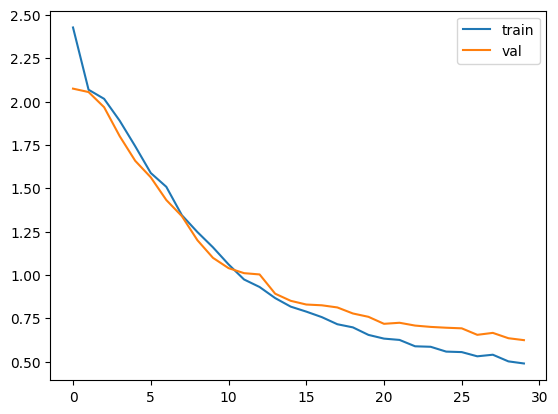

In [ ]:
for e in range(EPOCHS):
    batch_history = []
    # TRAIN STEP
    for images, labels in train_loader:
        # convert images to the correct device (GPU or CPU)
        images, labels = images.to(device), labels.to(device)
        # predict and compute loss
        preds = cnn(images)
        loss = criterion(preds, labels)
        batch_history.append(loss.item())
        # optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_history.append(np.mean(batch_history))

    batch_history = []
    # VALIDATION STEP
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            preds = cnn(images)
            loss = criterion(preds, labels)
            batch_history.append(loss.item())
        val_history.append(np.mean(batch_history))
    
    scheduler.step(val_history[-1])

    print(f"epoch: {e}\ttrain loss: {train_history[-1]:.4f}\tval loss: {val_history[-1]:.4f}")

plt.plot(train_history, label='train')
plt.plot(val_history, label='val')
plt.legend()

#### 7. Evaluation

In [ ]:
class_mapping = ['down', 'go', 'up', 'yes', 'stop', 'left', 'no', 'right']
